In [ ]:
!pip install ogb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/78.8 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.5 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU

from torch_geometric.utils import negative_sampling
from torch_geometric.data import Data

import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv, GINConv, GATConv
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator

2025-05-21 06:46:17.550604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747809977.570703    2032 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747809977.577121    2032 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-21 06:46:17.598727: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# If you use GPU, the device should be cuda
print('Device: {}'.format(device))

Device: cuda


In [ ]:
dataset = PygLinkPropPredDataset(name='ogbl-ddi', transform=T.ToSparseTensor()) # loading ogb-ddi
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

/local_disk0/.ephemeral_nfs/envs/pythonEnv-dec48932-7c53-4b8f-bd64-a1ed241d1ce5/lib/python3.12/site-packages/ogb/linkproppred/dataset_pyg.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experi

Dataset: PygLinkPropPredDataset():
Number of graphs: 1
Number of features: 0
Number of classes: 0


In [ ]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

In [ ]:
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [ ]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

In [ ]:
data = dataset[0]

In [ ]:
data

Data(num_nodes=4267, adj_t=[4267, 4267])

/databricks/python/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


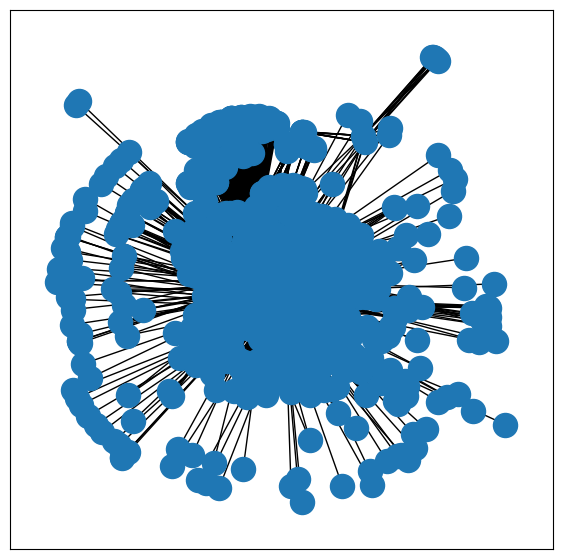

In [ ]:

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [ ]:
adj = data.adj_t
adj

tensor(crow_indices=tensor([      0,     451,     705,  ..., 2135754,
                            2135804, 2135822]),
       col_indices=tensor([   4,    6,    7,  ..., 3953, 3972, 4014]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]), size=(4267, 4267),
       nnz=2135822, layout=torch.sparse_csr)

In [ ]:
adj_coo = data.adj_t.to_sparse_coo()

Number of nodes: 4267
Number of edges: 1067911
Graph density: 0.1173
Sparse density:  0.8827
Average degree: 500.54
Median degree: 446.00
Max degree: 2234


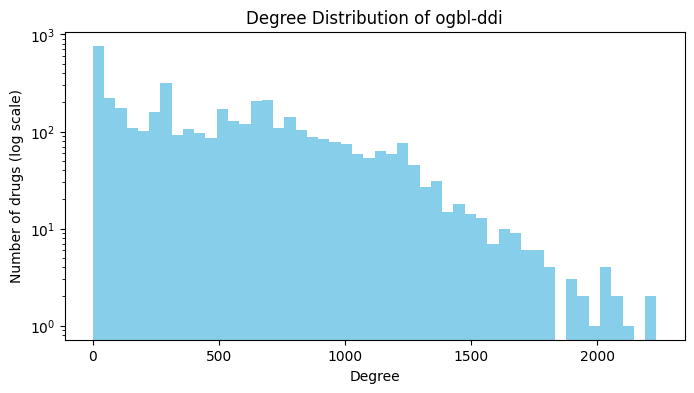

Top 5 hub drugs and their degree:
Drug 807: degree 2234
Drug 406: degree 2219
Drug 1037: degree 2118
Drug 299: degree 2091
Drug 260: degree 2091
Percentage of drugs with degree < 10: 9.49%
Percentage of drugs with degree > 500: 47.32%


In [ ]:
# Extract undirected edges (i < j only, to avoid duplicates)
import numpy as np
row, col = adj_coo.indices()
row, col = row.numpy(), col.numpy()
mask = row < col
src = row[mask]
dst = col[mask]

num_nodes = data.num_nodes
num_edges = len(src)
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Graph density: {num_edges / (num_nodes * (num_nodes - 1) / 2):.4f}")
print(f"Sparse density:  {1 - (num_edges / (num_nodes * (num_nodes - 1) / 2)):.4f}")

# Degree distribution
degrees = np.bincount(np.concatenate([src, dst]), minlength=num_nodes)
print(f"Average degree: {degrees.mean():.2f}")
print(f"Median degree: {np.median(degrees):.2f}")
print(f"Max degree: {degrees.max()}")

plt.figure(figsize=(8,4))
plt.hist(degrees, bins=50, color="skyblue")
plt.yscale('log')
plt.xlabel("Degree")
plt.ylabel("Number of drugs (log scale)")
plt.title("Degree Distribution of ogbl-ddi")
plt.show()

# Top 5 "hub" drugs (highest degree)
top_degrees = degrees.argsort()[::-1][:5]
print("Top 5 hub drugs and their degree:")
for idx in top_degrees:
    print(f"Drug {idx}: degree {degrees[idx]}")

# Percentage of nodes with degree < 10 (low-degree drugs)
low_deg = (degrees < 10).sum() / num_nodes * 100
print(f"Percentage of drugs with degree < 10: {low_deg:.2f}%")

# Percentage of nodes with degree > 500 (hubs)
hub_deg = (degrees > 500).sum() / num_nodes * 100
print(f"Percentage of drugs with degree > 500: {hub_deg:.2f}%")

Ego-network size (including center): 2235


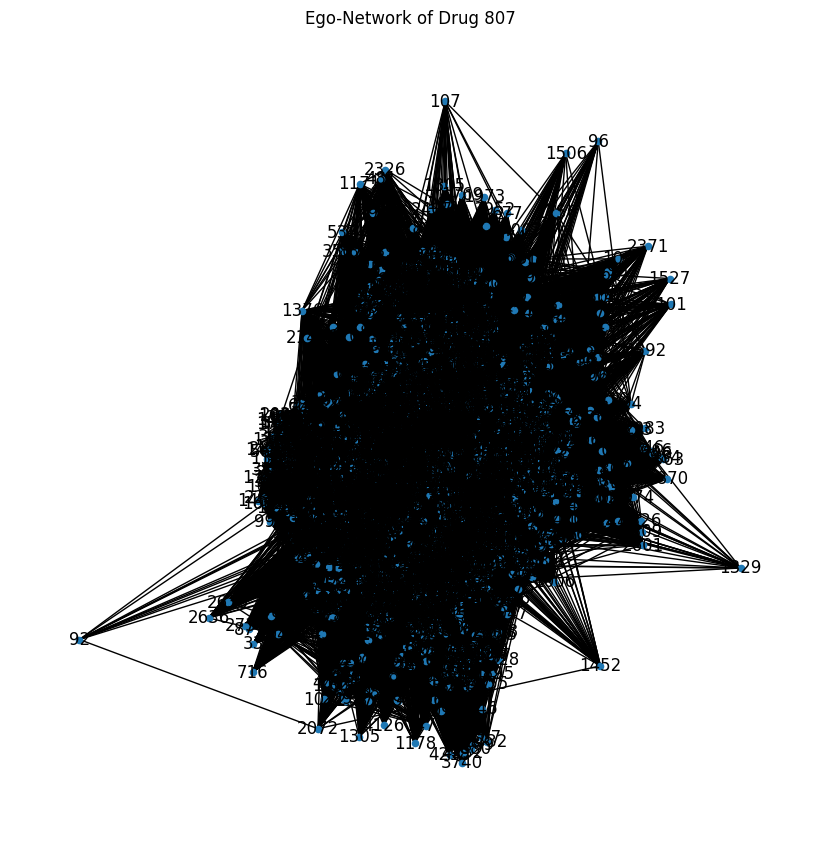

In [ ]:
import networkx as nx

# Convert the adjacency to a NetworkX graph (for visualization)
G = nx.Graph()
edges = list(zip(src, dst))
G.add_edges_from(edges)

# Extract the ego-network (one-hop neighborhood) of drug 807
ego_807 = nx.ego_graph(G, 807, radius=1)
print(f"Ego-network size (including center): {ego_807.number_of_nodes()}")

# Visualize (optional, requires matplotlib)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
nx.draw(ego_807, node_size=20, with_labels=True)
plt.title("Ego-Network of Drug 807")
plt.show()

In [ ]:
from networkx.algorithms import community

# Find communities using greedy modularity
communities = community.greedy_modularity_communities(G)
print(f"Number of detected communities: {len(communities)}")
print(f"Sizes of top 5 communities: {[len(c) for c in communities[:5]]}")

Number of detected communities: 5
Sizes of top 5 communities: [2474, 1512, 259, 19, 3]


In [ ]:
# List drugs with degree < 10
low_degree_drugs = np.where(degrees < 10)[0]
print("Low-degree drug indices:", low_degree_drugs[:10])
for idx in low_degree_drugs[:5]:
    neighbors = list(G.neighbors(idx))
    print(f"Drug {idx} has {len(neighbors)} neighbors: {neighbors}")

Low-degree drug indices: [  2  17  75  80  97  98  99 104 124 137]
Drug 2 has 4 neighbors: [9, 13, 2254, 2415]
Drug 17 has 9 neighbors: [229, 248, 297, 454, 462, 491, 1724, 2899, 3573]
Drug 75 has 8 neighbors: [20, 218, 220, 383, 1336, 1511, 2408, 3925]
Drug 80 has 3 neighbors: [527, 705, 1007]
Drug 97 has 1 neighbors: [502]


In [ ]:
for i, comm in enumerate(communities):
    print(f"Community {i} (size {len(comm)}): Example drugs {list(comm)[:10]}")

Community 0 (size 2474): Example drugs [0, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Community 1 (size 1512): Example drugs [4099, 4104, 4113, 4114, 4115, 4123, 4125, 4126, 4127, 4129]
Community 2 (size 259): Example drugs [1, 3079, 4108, 3087, 3092, 3093, 24, 3100, 3101, 4131]
Community 3 (size 19): Example drugs [1921, 1931, 3342, 3151, 3343, 4111, 16, 2129, 1809, 1489]
Community 4 (size 3): Example drugs [361, 3323, 3839]


In [ ]:
# Load node index to DrugBank ID mapping
node2drug_df = spark.read.csv("/Volumes/users/sarvesh_maheshwari/sarvesh_experiment/nodeidx2drugid.csv.gz", header=True, inferSchema=True)

# Load drug descriptions
drugdesc_df = spark.read.csv("/Volumes/users/sarvesh_maheshwari/sarvesh_experiment/ddi_description.csv.gz", header=True, inferSchema=True)

def remove_spaces_from_colnames(df):
    for col in df.columns:
        new_col = col.replace(" ", "_")
        df = df.withColumnRenamed(col, new_col)
    return df

# Apply to your DataFrames:
node2drug_df = remove_spaces_from_colnames(node2drug_df)
drugdesc_df = remove_spaces_from_colnames(drugdesc_df)

In [ ]:
display(node2drug_df.limit(10))
display(drugdesc_df.limit(10))

node_idx,drug_id
0,DB00001
1,DB00002
2,DB00004
3,DB00005
4,DB00006
5,DB00007
6,DB00008
7,DB00009
8,DB00011
9,DB00012


first_drug_id,first_drug_name,second_drug_id,second_drug_name,description
DB00001,Lepirudin,DB06605,Apixaban,Apixaban may increase the anticoagulant activities of Lepirudin.
DB00001,Lepirudin,DB06695,Dabigatran etexilate,Dabigatran etexilate may increase the anticoagulant activities of Lepirudin.
DB00001,Lepirudin,DB01254,Dasatinib,The risk or severity of bleeding and hemorrhage can be increased when Dasatinib is combined with Lepirudin.
DB00001,Lepirudin,DB01609,Deferasirox,The risk or severity of gastrointestinal bleeding can be increased when Lepirudin is combined with Deferasirox.
DB00001,Lepirudin,DB01586,Ursodeoxycholic acid,The risk or severity of bleeding and bruising can be increased when Lepirudin is combined with Ursodeoxycholic acid.
DB00001,Lepirudin,DB02123,Glycochenodeoxycholic Acid,The risk or severity of bleeding and bruising can be increased when Lepirudin is combined with Glycochenodeoxycholic Acid.
DB00001,Lepirudin,DB02659,Cholic Acid,The risk or severity of bleeding and bruising can be increased when Lepirudin is combined with Cholic Acid.
DB00001,Lepirudin,DB02691,Glycocholic acid,The risk or severity of bleeding and bruising can be increased when Lepirudin is combined with Glycocholic acid.
DB00001,Lepirudin,DB03619,Deoxycholic acid,The risk or severity of bleeding and bruising can be increased when Lepirudin is combined with Deoxycholic acid.
DB00001,Lepirudin,DB04348,Taurocholic acid,The risk or severity of bleeding and bruising can be increased when Lepirudin is combined with Taurocholic acid.


In [ ]:
# Now join as before
mapped_df = node2drug_df.join(drugdesc_df, node2drug_df.drug_id == drugdesc_df.first_drug_id, how='inner')

In [ ]:
from pyspark.sql.functions import col
display(mapped_df.filter(col("node_idx") == 2))

node_idx,drug_id,first_drug_id,first_drug_name,second_drug_id,second_drug_name,description
2,DB00004,DB00004,Denileukin diftitox,DB00012,Darbepoetin alfa,The risk or severity of Thrombosis can be increased when Darbepoetin alfa is combined with Denileukin diftitox.
2,DB00004,DB00004,Denileukin diftitox,DB00016,Erythropoietin,The risk or severity of Thrombosis can be increased when Erythropoietin is combined with Denileukin diftitox.
2,DB00004,DB00004,Denileukin diftitox,DB08894,Peginesatide,The risk or severity of Thrombosis can be increased when Peginesatide is combined with Denileukin diftitox.
2,DB00004,DB00004,Denileukin diftitox,DB09107,Methoxy polyethylene glycol-epoetin beta,The risk or severity of Thrombosis can be increased when Methoxy polyethylene glycol-epoetin beta is combined with Denileukin diftitox.


### Data Prep

In [ ]:
data = dataset[0]
row, col = adj_coo.indices()
row, col = row.numpy(), col.numpy()
edges = [(int(a), int(b)) for a, b in zip(row, col) if a < b]
G = nx.Graph()
G.add_nodes_from(range(data.num_nodes))  # Ensures nodes 0..N-1 are in the graph
G.add_edges_from(edges)

In [ ]:
split = dataset.get_edge_split()

/local_disk0/.ephemeral_nfs/envs/pythonEnv-dec48932-7c53-4b8f-bd64-a1ed241d1ce5/lib/python3.12/site-packages/ogb/linkproppred/dataset_pyg.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experi

In [ ]:
all_pairs = set((i, j) for i in range(data.num_nodes) for j in range(i+1, data.num_nodes))
print(len(all_pairs))

9101511


In [ ]:
all_pos = set((int(i), int(j)) for i, j in zip(row, col) if i < j)
len(all_pos)

1067911

In [ ]:
neg_candidates = list(all_pairs - all_pos)
len(neg_candidates)

8033600

In [ ]:
np.random.seed(42)

In [ ]:
train_edges = split['valid']['edge_neg']
len(train_edges)

101882

In [ ]:
import numpy as np
train_pos = split['train']['edge'].numpy()

# 2. Build set of ALL known edges (to avoid sampling them as negatives)
all_edges_set = set(tuple(sorted((int(u), int(v)))) for u, v in np.concatenate([
    split['train']['edge'].numpy(),
    split['valid']['edge'].numpy(),
    split['test']['edge'].numpy(),
]))

num_nodes = data.num_nodes
num_pos = len(train_pos)
print(num_pos)

1067911


In [ ]:
# 3. Sample negatives (equal to number of positives, not in known edges)
def sample_negatives(num_samples, num_nodes, forbidden):
    negs = set()
    while len(negs) < num_samples:
        u = np.random.randint(num_nodes)
        v = np.random.randint(num_nodes)
        if u == v:
            continue
        pair = tuple(sorted((u, v)))
        if pair not in forbidden:
            negs.add(pair)
    return list(negs)

train_neg = sample_negatives(num_pos, num_nodes, all_edges_set)
train_neg = np.array(train_neg, dtype=np.int32)  # Or np.int64 if needed
print(train_neg.shape)

(1067911, 2)


In [ ]:
# Precompute degree and neighbor sets for all nodes
degrees = dict(G.degree())
neighbors = {n: set(G.neighbors(n)) for n in G.nodes()}

In [ ]:
# Feature functions
def degree_sum(u, v):
    "Degree sum for (u, v) gives a sense of how “well-connected” the two drugs are, regardless of whether they are connected to each other."
    return degrees[u] + degrees[v]

def common_neighbors(u, v):
    "pairs with more shared neighbors are much more likely to have a link"
    return len(neighbors[u] & neighbors[v])

def jaccard(u, v):
    "fraction of shared neighbors out of all unique neighbors."
    inter = neighbors[u] & neighbors[v]
    union = neighbors[u] | neighbors[v]
    return len(inter) / len(union) if len(union) > 0 else 0.0


def adamic_adar(u, v):
    "Like common neighbors, but weighs rarer neighbors more"
    return sum(1 / np.log(degrees[w]) for w in neighbors[u] & neighbors[v] if degrees[w] > 1)


def preferential_attachment(u, v):
    "Product of degrees"
    return degrees[u] * degrees[v]



In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType

import pandas as pd
import math

# Broadcast your precomputed dicts
bd_deg = spark.sparkContext.broadcast(degrees)
bd_nei = spark.sparkContext.broadcast(neighbors)

def feature_udf(u, v):
    deg   = bd_deg.value
    nei   = bd_nei.value
    du, dv = deg.get(u, 0), deg.get(v, 0)
    nu, nv = nei.get(u, set()), nei.get(v, set())
    deg_sum  = du + dv
    cn       = len(nu & nv)
    union    = nu | nv
    jac      = len(nu & nv) / len(union) if union else 0.0
    aa       = sum(1.0 / math.log(deg[w]) for w in (nu & nv) if deg.get(w, 0) > 1)
    pa       = du * dv
    return [float(deg_sum), float(cn), float(jac), float(aa), float(pa)]

features_udf = udf(feature_udf, ArrayType(DoubleType()))

In [ ]:
import pandas as pd
import numpy as np

def build_candidate_df(pos_edges, neg_edges, shuffle=True, random_seed=42):
    # Combine positives and negatives
    candidates = [tuple(map(int, x)) for x in pos_edges] + [tuple(map(int, x)) for x in neg_edges]
    labels = [1]*len(pos_edges) + [0]*len(neg_edges)
    idxs = list(range(len(candidates)))

    # Build DataFrame
    df = pd.DataFrame({'idx': idxs, 'u': [u for u, v in candidates], 'v': [v for u, v in candidates], 'label': labels})

    if shuffle:
        # Shuffle the DataFrame rows and reset idx
        df = df.sample(frac=1, random_state=random_seed).reset_index(drop=True)
        df['idx'] = range(len(df))  # Re-assign new idx after shuffling

    return df

In [ ]:
#train
train_pos = split['train']['edge'].numpy()
train_df = build_candidate_df(train_pos, train_neg)
print(train_pos.shape, train_neg.shape)

(1067911, 2) (1067911, 2)


In [ ]:
val_pos = split['valid']['edge'].numpy()
val_neg = split['valid']['edge_neg'].numpy()
val_df = build_candidate_df(val_pos, val_neg)
print(val_pos.shape, val_neg.shape )

(133489, 2) (101882, 2)


In [ ]:
test_pos = split['test']['edge'].numpy()
test_neg = split['test']['edge_neg'].numpy()
test_df = build_candidate_df(test_pos, test_neg)
print(test_pos.shape, test_neg.shape )

(133489, 2) (95599, 2)


In [ ]:
spark_train_df = spark.createDataFrame(train_df)
spark_val_df   = spark.createDataFrame(val_df)
spark_test_df  = spark.createDataFrame(test_df)

spark_train_df = spark_train_df.withColumn("features", features_udf("u", "v"))
spark_val_df   = spark_val_df.withColumn("features", features_udf("u", "v"))
spark_test_df  = spark_test_df.withColumn("features", features_udf("u", "v"))

In [ ]:
def collect_features_labels(spark_df):
    rows = spark_df.select("idx", "features", "label").orderBy("idx").collect()
    features = np.array([row['features'] for row in rows])
    labels   = np.array([row['label']    for row in rows])
    return features, labels

features_train, labels_train = collect_features_labels(spark_train_df)
features_val, labels_val     = collect_features_labels(spark_val_df)
features_test, labels_test   = collect_features_labels(spark_test_df)

In [ ]:
mean = features_train.mean(axis=0)
std  = features_train.std(axis=0) + 1e-6

features_train_norm = (features_train - mean) / std
features_val_norm   = (features_val   - mean) / std
features_test_norm  = (features_test  - mean) / std

Model

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver="lbfgs", max_iter=1000)
lr.fit(features_train_norm, labels_train)

# Predict
marginals_val = lr.predict_proba(features_val_norm)[:, 1]
marginals_test = lr.predict_proba(features_test_norm)[:, 1]

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
import numpy as np
from ogb.linkproppred import Evaluator

# 1) Pull out the pos/neg edge arrays
val_pos = split['valid']['edge'].numpy()      # shape (N_val, 2)
val_neg = split['valid']['edge_neg'].numpy()  # shape (N_val, 2)
test_pos = split['test']['edge'].numpy()      # shape (N_test, 2)
test_neg = split['test']['edge_neg'].numpy()  # shape (N_test, 2)

# 2) Compute features separately for positives and negatives
def compute_feats(edges):
    feats = np.zeros((len(edges), 5))
    for i, (u, v) in enumerate(edges):
        feats[i, 0] = degree_sum(u, v)
        feats[i, 1] = common_neighbors(u, v)
        feats[i, 2] = jaccard(u, v)
        feats[i, 3] = adamic_adar(u, v)
        feats[i, 4] = preferential_attachment(u, v)
    return feats

feats_val_pos = compute_feats(val_pos)
feats_val_neg = compute_feats(val_neg)
feats_test_pos = compute_feats(test_pos)
feats_test_neg = compute_feats(test_neg)

# 3) Normalize using training mean/std
mean = features_train.mean(axis=0)
std  = features_train.std(axis=0) + 1e-6

feats_val_pos = (feats_val_pos - mean) / std
feats_val_neg = (feats_val_neg - mean) / std
feats_test_pos = (feats_test_pos - mean) / std
feats_test_neg = (feats_test_neg - mean) / std

# 4) Get predicted probabilities for class=1
pos_val_pred = lr.predict_proba(feats_val_pos)[:, 1]
neg_val_pred = lr.predict_proba(feats_val_neg)[:, 1]
pos_test_pred = lr.predict_proba(feats_test_pos)[:, 1]
neg_test_pred = lr.predict_proba(feats_test_neg)[:, 1]

# 5) Use OGB Evaluator for paired Hits@K
evaluator = Evaluator(name='ogbl-ddi')



Hits@1 — Valid: 0.0000, Test: 0.0035
Hits@3 — Valid: 0.0360, Test: 0.0113
Hits@5 — Valid: 0.0416, Test: 0.0133
Hits@10 — Valid: 0.0490, Test: 0.0228


In [ ]:
for K in [1, 3, 5, 10, 20 , 50]:
    evaluator.K = K
    val_res = evaluator.eval({
        'y_pred_pos': pos_val_pred,
        'y_pred_neg': neg_val_pred,
    })
    test_res = evaluator.eval({
        'y_pred_pos': pos_test_pred,
        'y_pred_neg': neg_test_pred,
    })
    print(f"Hits@{K} — Valid: {val_res[f'hits@{K}']:.4f}, Test: {test_res[f'hits@{K}']:.4f}")

Hits@1 — Valid: 0.0000, Test: 0.0035
Hits@3 — Valid: 0.0360, Test: 0.0113
Hits@5 — Valid: 0.0416, Test: 0.0133
Hits@10 — Valid: 0.0490, Test: 0.0228
Hits@20 — Valid: 0.1247, Test: 0.0737
Hits@50 — Valid: 0.2662, Test: 0.3123


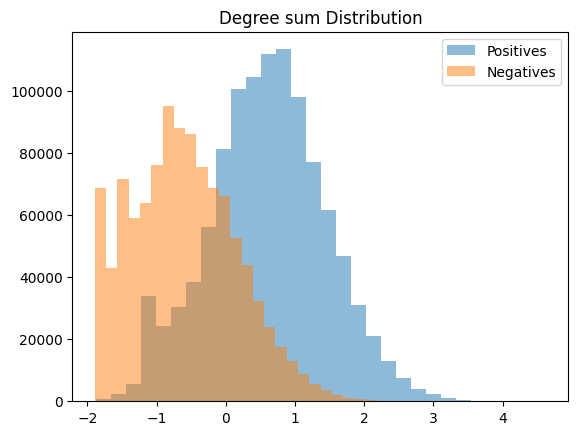

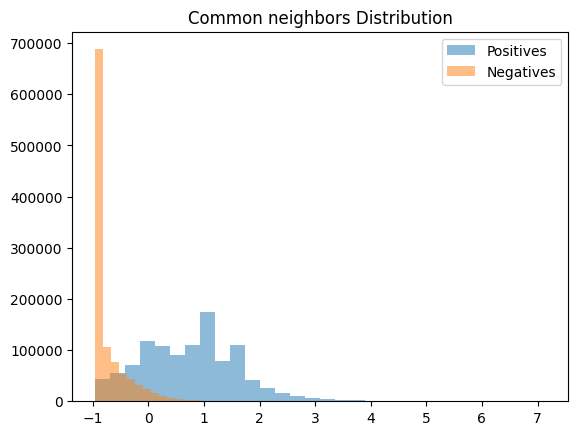

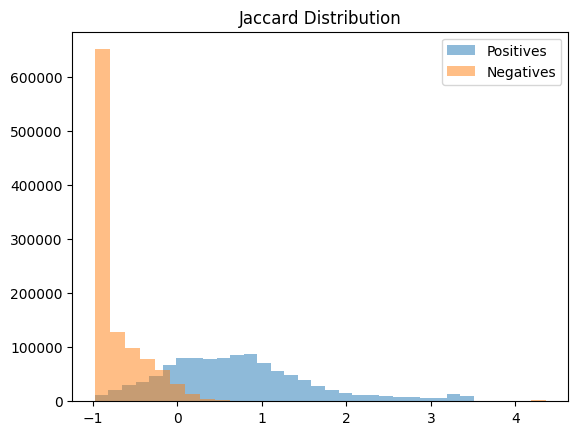

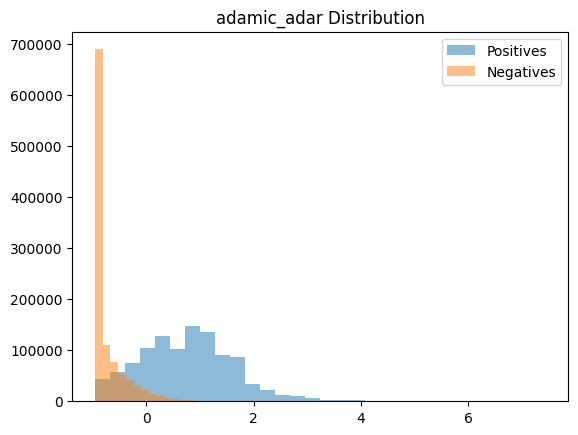

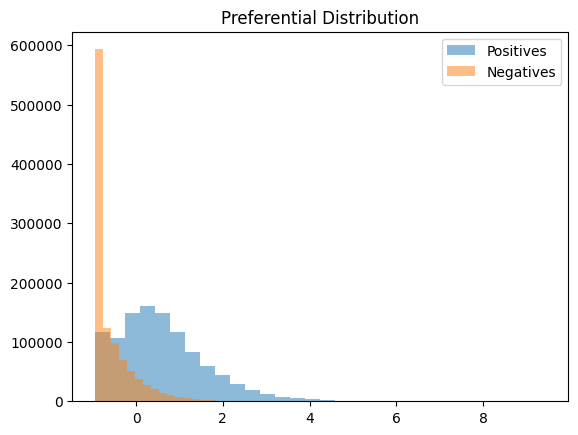

In [ ]:
import matplotlib.pyplot as plt

for i, name in enumerate(['Degree sum', 'Common neighbors', 'Jaccard', 'adamic_adar', 'Preferential']):
    plt.figure()
    plt.hist(features_train_norm[np.array(labels_train)==1][:, i], bins=30, alpha=0.5, label='Positives')
    plt.hist(features_train_norm[np.array(labels_train)==0][:, i], bins=30, alpha=0.5, label='Negatives')
    plt.title(f'{name} Distribution')
    plt.legend()
    plt.show()

Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EdgePredictor(nn.Module):
    def __init__(self, in_dim, hidden_dim=32, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.out(x)
        return torch.sigmoid(x).squeeze(-1)   # Probability output

# Instantiate
model = EdgePredictor(features_train_norm.shape[1], hidden_dim=64)
model.to(device)  # if using GPU

EdgePredictor(
  (fc1): Linear(in_features=5, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
import torch.optim as optim

# Convert data to torch tensors
X_train = torch.tensor(features_train_norm, dtype=torch.float32)
y_train = torch.tensor(labels_train, dtype=torch.float32)
X_val = torch.tensor(features_val_norm, dtype=torch.float32)
y_val = torch.tensor(labels_val, dtype=torch.float32)

# Move to GPU if available
if torch.cuda.is_available():
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_val = X_val.to(device)
    y_val = y_val.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

for epoch in range(300):  # or more epochs
    model.train()
    optimizer.zero_grad()
    out = model(X_train)
    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()

    # Optionally evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        val_loss = criterion(val_pred, y_val)
    print(f"Epoch {epoch}: Train Loss {loss.item():.4f}, Val Loss {val_loss.item():.4f}")

Epoch 0: Train Loss 0.6778, Val Loss 0.6743
Epoch 1: Train Loss 0.6662, Val Loss 0.6630
Epoch 2: Train Loss 0.6547, Val Loss 0.6520
Epoch 3: Train Loss 0.6434, Val Loss 0.6414
Epoch 4: Train Loss 0.6323, Val Loss 0.6309
Epoch 5: Train Loss 0.6213, Val Loss 0.6206
Epoch 6: Train Loss 0.6105, Val Loss 0.6103
Epoch 7: Train Loss 0.5998, Val Loss 0.6001
Epoch 8: Train Loss 0.5891, Val Loss 0.5899
Epoch 9: Train Loss 0.5786, Val Loss 0.5797
Epoch 10: Train Loss 0.5681, Val Loss 0.5695
Epoch 11: Train Loss 0.5577, Val Loss 0.5594
Epoch 12: Train Loss 0.5473, Val Loss 0.5492
Epoch 13: Train Loss 0.5370, Val Loss 0.5391
Epoch 14: Train Loss 0.5267, Val Loss 0.5290
Epoch 15: Train Loss 0.5163, Val Loss 0.5190
Epoch 16: Train Loss 0.5061, Val Loss 0.5091
Epoch 17: Train Loss 0.4960, Val Loss 0.4993
Epoch 18: Train Loss 0.4859, Val Loss 0.4897
Epoch 19: Train Loss 0.4759, Val Loss 0.4801
Epoch 20: Train Loss 0.4660, Val Loss 0.4707
Epoch 21: Train Loss 0.4565, Val Loss 0.4615
Epoch 22: Train Loss

In [ ]:
import torch
import numpy as np
from ogb.linkproppred import Evaluator

# 1. Assuming compute_feats, mean, std as before
# feats_val_pos = (compute_feats(val_pos) - mean) / std
# feats_val_neg = (compute_feats(val_neg) - mean) / std
# feats_test_pos = (compute_feats(test_pos) - mean) / std
# feats_test_neg = (compute_feats(test_neg) - mean) / std

# 2. Convert features to torch tensors and move to GPU if using one
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feats_val_pos_torch = torch.tensor(feats_val_pos, dtype=torch.float32, device=device)
feats_val_neg_torch = torch.tensor(feats_val_neg, dtype=torch.float32, device=device)
feats_test_pos_torch = torch.tensor(feats_test_pos, dtype=torch.float32, device=device)
feats_test_neg_torch = torch.tensor(feats_test_neg, dtype=torch.float32, device=device)

# 3. Get predicted probabilities (sigmoid output)
model.eval()
with torch.no_grad():
    pos_val_pred = model(feats_val_pos_torch).cpu().numpy()  # shape (N_val,)
    neg_val_pred = model(feats_val_neg_torch).cpu().numpy()
    pos_test_pred = model(feats_test_pos_torch).cpu().numpy()
    neg_test_pred = model(feats_test_neg_torch).cpu().numpy()

# 4. Use OGB Evaluator for paired Hits@K
evaluator = Evaluator(name='ogbl-ddi')
for K in [10, 20, 50, 100]:
    evaluator.K = K
    res_val = evaluator.eval({'y_pred_pos': pos_val_pred, 'y_pred_neg': neg_val_pred})
    res_test = evaluator.eval({'y_pred_pos': pos_test_pred, 'y_pred_neg': neg_test_pred})
    print(f"Validation Hits@{K}: {res_val[f'hits@{K}']:.4f}")
    print(f"Test Hits@{K}: {res_test[f'hits@{K}']:.4f}")

Validation Hits@10: 0.1680
Test Hits@10: 0.2333
Validation Hits@20: 0.2513
Test Hits@20: 0.2815
Validation Hits@50: 0.3930
Test Hits@50: 0.4517
Validation Hits@100: 0.4800
Test Hits@100: 0.5058


Deep Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeepEdgePredictor(nn.Module):
    def __init__(self, in_dim, hidden_dims=[128, 128, 64, 32], dropout=0.4):
        super().__init__()
        self.layers = nn.ModuleList()
        prev = in_dim
        for h in hidden_dims:
            self.layers.append(nn.Linear(prev, h))
            prev = h
        self.out = nn.Linear(prev, 1)
        self.dropout = nn.Dropout(dropout)
        self.batchnorms = nn.ModuleList([nn.BatchNorm1d(h) for h in hidden_dims])

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            x = self.batchnorms[i](x)
            x = F.relu(x)
            x = self.dropout(x)
        x = self.out(x)
        return torch.sigmoid(x).squeeze(-1)

# Instantiate
model = DeepEdgePredictor(features_train_norm.shape[1]).to(device)
model

DeepEdgePredictor(
  (layers): ModuleList(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
  )
  (out): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (batchnorms): ModuleList(
    (0-1): 2 x BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Convert numpy arrays to torch tensors
X_train = torch.tensor(features_train_norm, dtype=torch.float32)
y_train = torch.tensor(labels_train, dtype=torch.float32)
X_val = torch.tensor(features_val_norm, dtype=torch.float32)
y_val = torch.tensor(labels_val, dtype=torch.float32)

# Move tensors to device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)

# DataLoader for batching
batch_size = 4096   # You can increase this if you have enough GPU memory
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

In [ ]:
# Optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()   # For binary link prediction

best_val_loss = float('inf')
epochs = 3

for epoch in range(1, epochs+1):
    # ----- Training -----
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_loader.dataset)

    # ----- Validation -----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch:2d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        best_val_loss = val_loss

# (Optional) Load the best model
model.load_state_dict(torch.load('best_model.pt'))

Epoch  1 | Train Loss: 0.1975 | Val Loss: 0.1977
Epoch  2 | Train Loss: 0.1944 | Val Loss: 0.1927
Epoch  3 | Train Loss: 0.1926 | Val Loss: 0.1929


/root/.ipykernel/2032/command-4524483445351525-1684978413:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


<All keys matched successfully>

In [ ]:
import torch
import numpy as np
from ogb.linkproppred import Evaluator

# 1. Assuming compute_feats, mean, std as before
# feats_val_pos = (compute_feats(val_pos) - mean) / std
# feats_val_neg = (compute_feats(val_neg) - mean) / std
# feats_test_pos = (compute_feats(test_pos) - mean) / std
# feats_test_neg = (compute_feats(test_neg) - mean) / std

# 2. Convert features to torch tensors and move to GPU if using one
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feats_val_pos_torch = torch.tensor(feats_val_pos, dtype=torch.float32, device=device)
feats_val_neg_torch = torch.tensor(feats_val_neg, dtype=torch.float32, device=device)
feats_test_pos_torch = torch.tensor(feats_test_pos, dtype=torch.float32, device=device)
feats_test_neg_torch = torch.tensor(feats_test_neg, dtype=torch.float32, device=device)

# 3. Get predicted probabilities (sigmoid output)
model.eval()
with torch.no_grad():
    pos_val_pred = model(feats_val_pos_torch).cpu().numpy()  # shape (N_val,)
    neg_val_pred = model(feats_val_neg_torch).cpu().numpy()
    pos_test_pred = model(feats_test_pos_torch).cpu().numpy()
    neg_test_pred = model(feats_test_neg_torch).cpu().numpy()

# 4. Use OGB Evaluator for paired Hits@K
evaluator = Evaluator(name='ogbl-ddi')
for K in [10, 20, 50, 100]:
    evaluator.K = K
    res_val = evaluator.eval({'y_pred_pos': pos_val_pred, 'y_pred_neg': neg_val_pred})
    res_test = evaluator.eval({'y_pred_pos': pos_test_pred, 'y_pred_neg': neg_test_pred})
    print(f"Validation Hits@{K}: {res_val[f'hits@{K}']:.4f}")
    print(f"Test Hits@{K}: {res_test[f'hits@{K}']:.4f}")

Validation Hits@10: 0.1555
Test Hits@10: 0.2112
Validation Hits@20: 0.2447
Test Hits@20: 0.2617
Validation Hits@50: 0.4030
Test Hits@50: 0.4158
Validation Hits@100: 0.4909
Test Hits@100: 0.5097
